In this post, we'll look at the *obstacle problem*.
We've seen in previous posts examples of variational problems -- minimization of some functional with respect to a field.
The classic example of a variational problem is to find the function $u$ that minimizes the Dirichlet energy

$$\mathscr{J}(u) = \int_\Omega\left(\frac{1}{2}|\nabla u|^2 - fu\right)dx$$

subject to the homogeneous Dirichlet boundary condition $u|_{\partial\Omega} = 0$.
The Poisson equation is especially convenient because the objective is convex and quadratic.
The obstacle problem is what you get when you add the additional constraint

$$u \ge g$$

throughout the domain.
More generally, we can look at the problem of minimizing a convex functional $\mathscr{J}$ subject to the constraint that $u$ has to live in a closed, convex set $K$ of a function space $Q$.
For a totally unconstrained problem, $K$ would just be the whole space $Q$.

Newton's method with line search is a very effective algorithm for solving unconstrained convex problems, even for infinite-dimensional problems like PDEs.
Things get much harder when you include inequality constraints.
To make matters worse, much of the literature you'll find on this subject is focused on finite-dimensional problems, where techniques like the active-set method work quite well.
It's not so obvious how to generalize these methods to variational problems.
In the following, I'll follow the approach in section 4.1 of [this paper](https://www.tandfonline.com/doi/full/10.1080/10556788.2019.1613655) by Farrell, Croci, and Surowiec, whch was my inspiration for writing this post.

Minimizing the action functional $\mathscr{J}$ over the convex set $K$ can be rephrased as an unconstrained problem to minimize the functional

$$\mathscr{J}(u) + \mathscr{I}(u),$$

where $\mathscr{I}$ is the *indicator function* of the set $K$:

$$\mathscr{I}(u) = \begin{cases}0 & u \in K \\ \infty & u \notin K\end{cases}.$$

This functional is still convex, but it can take the value $\infty$.
The reformulation isn't especially useful by itself, but we can approximate it using the *Moreau envelope*.
The envelope of $\mathscr{I}$ is defined as

$$\mathscr{I}_\gamma(u) = \min_v\left(\mathscr{I}(v) + \frac{1}{2\gamma^2}\|u - v\|^2\right).$$

In the limit as $\gamma \to 0$, $\mathscr{I}_\gamma(u) \to \mathscr{I}(u)$.
The Moreau envelope is much easier to work with than the original functional because it's differentiable.
In some cases it can be computed analytically; for example, when $\mathscr{I}$ is an indicator function,

$$\mathscr{I}_\gamma(u) = \frac{1}{2\gamma^2}\text{dist}\,(u, K)^2$$

where $\text{dist}$ is the distance to a convex set.
We can do even better for our specific case, where $K$ is the set of all functions greater than $g$.
For this choice of $K$, the distance to $K$ is

$$\text{dist}(u, K)^2 = \int_\Omega(u - g)_-^2dx,$$

where $v_- = \min(v, 0)$ is the negative part of $v$.
So, our approach to solving the obstacle problem will be to find the minimzers of

$$\mathscr{J}_\gamma(u) = \int_\Omega\left(\frac{1}{2}|\nabla u|^2 - fu\right)dx + \frac{1}{2\gamma^2}\int_\Omega(u - g)_-^2dx$$

as $\gamma$ goes to 0.
I've written things in such a way that $\gamma$ has units of length.
Rather than take $\gamma$ to 0 we can instead stop at some fraction of the finite element mesh spacing.
At that point, the errors in the finite element approximation are comparable to the distance of the approximate solution to the constraint set.

This is a lot like the penalty method for optimization problems with equality constraints.
One of the main practical considerations when applying this regularization method is that the solution $u$ only satisfies the inequality constraints approximately.
For the obstacle problem this deficiency isn't so severe, but for other problems we may need the solution to stay strictly feasible.
In those cases, another approach like the logarithmic barrier method might be more appropriate.

### Demonstration

For our problem, the domain will be the unit square and the obstacle function $g$ will be the upper half of a sphere.

In [1]:
import firedrake
nx, ny = 64, 64
mesh = firedrake.UnitSquareMesh(nx, ny, quadrilateral=True)
Q = firedrake.FunctionSpace(mesh, family='CG', degree=1)

In [2]:
from firedrake import max_value, sqrt, inner, as_vector, Constant

def make_obstacle(mesh):
    x = firedrake.SpatialCoordinate(mesh)
    y = as_vector((1/2, 1/2))
    z = 1/4
    return sqrt(max_value(z**2 - inner(x - y, x - y), 0))

g = firedrake.interpolate(make_obstacle(mesh), Q)

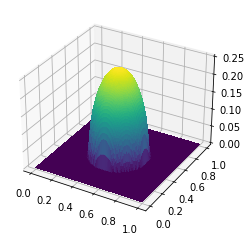

In [3]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
fig = plt.figure()
axes = fig.add_subplot(projection='3d')
firedrake.trisurf(g, axes=axes);

Next we'll make a few utility procedures to create the Moreau envelope of the objective functional and to calculate a search direction from a given starting guess.

In [4]:
from firedrake import grad, dx, min_value

def make_objective(u, g, γ):
    J_elastic = 0.5 * inner(grad(u), grad(u)) * dx
    J_penalty = 0.5 / γ**2 * min_value(u - g, 0)**2 * dx
    return J_elastic + J_penalty

In [5]:
from firedrake import derivative
def update_search_direction(J, u, v):
    F = derivative(J, u)
    H = derivative(F, u)

    bc = firedrake.DirichletBC(u.function_space(), 0, 'on_boundary')
    params = {'ksp_type': 'cg', 'pc_type': 'icc'}
    firedrake.solve(H == -F, v, bc, solver_parameters=params)

Let's start from a zero initial guess and see what the first search direction will be.

In [6]:
u = firedrake.Function(Q)
γ = Constant(1.)
J = make_objective(u, g, γ)

v = firedrake.Function(Q)
update_search_direction(J, u, v)

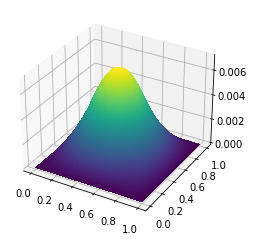

In [7]:
fig = plt.figure()
axes = fig.add_subplot(projection='3d')
firedrake.trisurf(v, axes=axes);

To make sure that a Newton-type method will converge, we'll need a routine to perform a 1D minimization along the search direction.

In [8]:
from scipy.optimize import minimize_scalar
from firedrake import assemble, replace

def line_search(J, u, v):
    def J_line(step):
        t = firedrake.Constant(step)
        J_t = replace(J, {u: u + t * v})
        return assemble(J_t)

    result = minimize_scalar(J_line)
    assert result.success
    return result.x

In [9]:
t = line_search(J, u, v)
print(t)

1.0000833865577647


With these steps out of the way we can define a Newton search procedure and calculate a solution for our initial, rough guess of $\gamma$.

In [10]:
from firedrake import action
def newton_search(J, u, tolerance=1e-10, max_num_steps=30):
    v = firedrake.Function(u.function_space())
    F = derivative(J, u)
    
    for step in range(max_num_steps):
        update_search_direction(J, u, v)
        
        Δ = assemble(action(F, v))
        if abs(Δ) < tolerance * assemble(J):
            return

        t = Constant(line_search(J, u, v))
        u.assign(u + t * v)

In [11]:
newton_search(J, u)

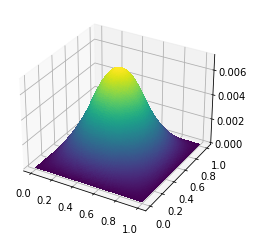

In [12]:
fig = plt.figure()
axes = fig.add_subplot(projection='3d')
firedrake.trisurf(u, axes=axes);

The solution we obtain doesn't do a good job of staying above the obstacle because we haven't used a sufficiently small value of $\gamma$.

In [13]:
δ = firedrake.interpolate(max_value(g - u, 0), Q)
print(firedrake.assemble(δ * dx) / firedrake.assemble(g * dx))

0.9680039453017546


Instead, we can use the solution obtained for one value of $\gamma$ to initialize a search for the solution with $\gamma / 2$ and iterate.
We've chosen this slightly indirect route rather than start from a small value of $\gamma$ directly because the problem may be very poorly conditioned.
The numerical continuation approach can still give a reasonable answer even for poorly-conditioned problems.

In [14]:
def continuation_search(g, γ0, num_steps, contraction=0.5):
    u = g.copy(deepcopy=True)
    γ = Constant(γ0)

    for step in range(num_steps):
        J = make_objective(u, g, γ)
        newton_search(J, u)
        γ.assign(contraction * γ)

    return u

We'll choose a number of steps so that the final value of $\gamma$ is roughly proportional to the mesh spacing.

In [15]:
import numpy as np
num_steps = int(np.log2(nx)) + 1
print(num_steps)

u = continuation_search(g, 1., num_steps)

7


Finally, I'll plot a cross section of the solution and the constraint $g$ so that you can see where the two coincide.

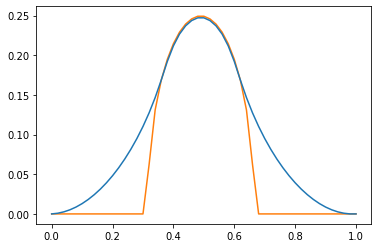

In [16]:
fig, axes = plt.subplots()
num_points = 51
xs = np.linspace(0., 1., num_points)
ys = 0.5 * np.ones(num_points)
X = np.array((xs, ys)).T
axes.plot(xs, g.at(X), color='tab:orange')
axes.plot(xs, u.at(X), color='tab:blue');

### Refinement

The code above worked well enough for a single grid, but one of the hard parts about optimization with PDE constraints is making sure that our algorithms do sane things under mesh refinement.
Many common algorithms can have different convergence rates depending on the mesh or the degree of the finite element basis.
The reasons for this are a little involved, but if you want to read more, I recommend [this book](https://epubs.siam.org/doi/book/10.1137/1.9781611973846) by Málek and Strakos.

To really make sure we're doing things right, we should run this experiment at several levels of mesh refinement.
We can do this easily using the `MeshHierarchy` function in Firedrake.

In [17]:
coarse_mesh = firedrake.UnitSquareMesh(nx, ny, quadrilateral=True)
num_levels = 3
mesh_hierarchy = firedrake.MeshHierarchy(coarse_mesh, num_levels)

for level, mesh in enumerate(mesh_hierarchy):
    Q = firedrake.FunctionSpace(mesh, family='CG', degree=1)
    g = firedrake.interpolate(make_obstacle(mesh), Q)
    num_continuation_steps = int(np.log(nx)) + level + 1
    u = continuation_search(g, 1, num_continuation_steps)
    print(assemble(max_value(g - u, 0) * dx))

0.0034424020045330894
0.0009409740393031862
0.00024126075715710023
6.073519021737773e-05


If we plot the volume of the region where $u$ is less than $g$, it decreases roughly by a factor of four on every mesh refinement.
This rate of decrease makes sense -- the area of each cell decreases by the same amount on each refinement.
Doing a more thorough convergence study would require more computational power, but for now this is a promising sign that our algorithm works right.

### Discussion

We were able to get a convergent approximation scheme for the obstacle problem by expressing the constraint as an indicator functional and then using Moreau-Yosida regularization.
The idea of regularizing non-smooth optimization problems is a more general trick; we can use it for things like $L^1$ or total variation penalties as well.
The Moreau envelope is another angle to look at [proximal algorithms](https://web.stanford.edu/~boyd/papers/pdf/prox_algs.pdf) from too.

For the obstacle problem, regularization made it possible to describe every part of the algorithm using higher-level concepts (fields, functionals) without having to dive down to lower levels of abstraction (matrices, vectors).
In order to implement other approaches, like the active set method, we would have no choice but to pull out the PETSc matrices and vectors that lie beneath, which is a more demanding prospect.